## OVERVIEW OF OSEMiN

<img src='https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/OSEMN.png' width=800>

<center><a href="https://www.kdnuggets.com/2018/02/data-science-command-line-book-exploring-data.html"> 
    </a></center>


> <font size=2em>The Data Science Process we'll be using during this section--OSEMiN (pronounced "OH-sum", rhymes with "possum").  This is the most straightforward of the Data Science Processes discussed so far.  **Note that during this process, just like the others, the stages often blur together.***  It is completely acceptable (and ***often a best practice!) to float back and forth** between stages as you learn new things about your problem, dataset, requirements, etc.  
It's quite common to get to the modeling step and realize that you need to scrub your data a bit more or engineer a different feature and jump back to the "Scrub" stage, or go all the way back to the "Obtain" stage when you realize your current data isn't sufficient to solve this problem. 
As with any of these frameworks, *OSEMiN is meant to be treated as guidelines, not law. 
</font>


### OSEMN DETAILS

**OBTAIN**

- This step involves understanding stakeholder requirements, gathering information on the problem, and finally sourcing data that we think will be necessary for solving this problem. 

**SCRUB**

- During this stage, we'll focus on preprocessing our data.  Important steps such as identifying and removing null values, dealing with outliers, normalizing data, and feature engineering/feature selection are handled around this stage.  The line with this stage really blurs with the _Explore_ stage, as it is common to only realize that certain columns require cleaning or preprocessing as a result of the visualzations and explorations done during Step 3.  

- Note that although technically, categorical data should be one-hot encoded during this step, in practice, it's usually done after data exploration.  This is because it is much less time-consuming to visualize and explore a few columns containing categorical data than it is to explore many different dummy columns that have been one-hot encoded. 

**EXPLORE**

- This step focuses on getting to know the dataset you're working with. As mentioned above, this step tends to blend with the _Scrub_ step mentioned above.  During this step, you'll create visualizations to really get a feel for your dataset.  You'll focus on things such as understanding the distribution of different columns, checking for multicollinearity, and other tasks liek that.  If your project is a classification task, you may check the balance of the different classes in your dataset.  If your problem is a regression task, you may check that the dataset meets the assumptions necessary for a regression task.  

- At the end of this step, you should have a dataset ready for modeling that you've thoroughly explored and are extremely familiar with.  

**MODEL**

- This step, as with the last two frameworks, is also pretty self-explanatory. It consists of building and tuning models using all the tools you have in your data science toolbox.  In practice, this often means defining a threshold for success, selecting machine learning algorithms to test on the project, and tuning the ones that show promise to try and increase your results.  As with the other stages, it is both common and accepted to realize something, jump back to a previous stage like _Scrub_ or _Explore_, and make some changes to see how it affects the model.  

**iNTERPRET**

- During this step, you'll interpret the results of your model(s), and communicate results to stakeholders.  As with the other frameworks, communication is incredibily important! During this stage, you may come to realize that further investigation is needed, or more data.  That's totally fine--figure out what's needed, go get it, and start the process over! If your results are satisfactory to all stakeholders involved, you may also go from this stage right into productionizing your model and automating processes necessary to support it.  





## PROCESS CHECKLIST


> Keep in mind that it is normal to jump between the OSEMN phases and some of them will blend together, like SCRUB and EXPLORE.

1. **[OBTAIN](#OBTAIN)**
    - Import data, inspect, check for datatypes to convert and null values
    - Display header and info.
    - Drop any unneeded columns, if known (`df.drop(['col1','col2'],axis=1,inplace=True`)
    <br><br>


2. **[SCRUB](#SCRUB)**
    - Recast data types, identify outliers, check for multicollinearity, normalize data**
    - Check and cast data types
        - [ ] Check for #'s that are store as objects (`df.info()`,`df.describe()`)
            - when converting to #'s, look for odd values (like many 0's), or strings that can't be converted.
            - Decide how to deal weird/null values (`df.unique()`, `df.isna().sum()`)
            - `df.fillna(subset=['col_with_nulls'],'fill_value')`, `df.replace()`
        - [ ] Check for categorical variables stored as integers.
            - May be easier to tell when you make a scatter plotm or `pd.plotting.scatter_matrix()`
            
    - [ ] Check for missing values  (df.isna().sum())
        - Can drop rows or colums
        - For missing numeric data with median or bin/convert to categorical
        - For missing categorical data: make NaN own category OR replace with most common category
    - [ ] Check for multicollinearity
        - Use seaborn to make correlation matrix plot 
        - Good rule of thumb is anything over 0.75 corr is high, remove the variable that has the most correl with the largest # of variables
    - [ ] Normalize data (may want to do after some exploring)
        - Most popular is Z-scoring (but won't fix skew) 
        - Can log-transform to fix skewed data
    
    
3. **[EXPLORE](#EXPLORE)**
    - [ ] Check distributions, outliers, etc**
    - [ ] Check scales, ranges (df.describe())
    - [ ] Check histograms to get an idea of distributions (df.hist()) and data transformations to perform.
        - Can also do kernel density estimates
    - [ ] Use scatter plots to check for linearity and possible categorical variables (`df.plot("x","y")`)
        - categoricals will look like vertical lines
    - [ ] Use `pd.plotting.scatter_matrix(df)` to visualize possible relationships
    - [ ] Check for linearity.
   
   
4. **[MODEL](#MODEL)**

    - **Fit an initial model:** 
        - Run an initial model and get results

    - **Holdout validation / Train/test split**
        - use sklearn `train_test_split`
    
    
5. **[iNTERPRET](#iNTERPRET)**
    - **Assessing the model:**
        - Assess parameters (slope,intercept)
        - Check if the model explains the variation in the data (RMSE, F, R_square)
        - *Are the coeffs, slopes, intercepts in appropriate units?*
        - *Whats the impact of collinearity? Can we ignore?*
        <br><br>
    - **Revise the fitted model**
        - Multicollinearity is big issue for lin regression and cannot fully remove it
        - Use the predictive ability of model to test it (like R2 and RMSE)
        - Check for missed non-linearity
        
       
6. **Interpret final model and draw >=3 conclusions and recommendations from dataset**

<div style="display:block;border-bottom:solid red 3px;padding:1.4em;color:red;font-size:30pt;display:inline-block;line-height:1.5em;">
DELETE THIS CELL AND EVERYTHING ABOVE FROM YOUR FINAL NOTEBOOK
</div>

# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time:
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.

In the world we live in today, social media affects not only our personal lives but the day-to-day operations of businesses as well. With the world being more connected than ever, it is crucial for businesses to be able to read the public opinion about their products and brand, and adapt to changing trends as quickly as possible or even stay ahead of them. Staying connected and being in-the-know not only allows businesses to stay relevant but also provides them with opportunities to achieve and maintain financial success.

One of the many applications of this idea is when large companies such as Apple or Google hold their keynotes (Apple's WWDC or Google's I/O for example) and release new products, software updates and tease upcoming changes to their services. Another is when senior leadership within these companies attend large conferences and talk about the vision of their company and provide fans with hints as to what they can expect in the future. These are golden opportunities for these companies' marketing teams to gauge interest and gather information on public opinion.

One medium that companies can utilize to read public opinion is Twitter. Millions of people share their thoughts on various topics on Twitter every day, so this makes Twitter a great resource for businesses. For this project, we were hired by Apple to conduct a sentiment analysis of tweets from the SXSW (South by Southwest) Conference. Below are the questions we will be providing insights for:

1. How is Apple perceived as a company during the SXSW Conference, and how does this compare to Google as one of their main competitors?

2. How are Apple and Google's products and announcements perceived during the SXSW Conference? Are there specific pain points within the products that Apple should address?

Additionally, we will be training and testing different machine learning models that can classify tweets based on their sentiment. Apple can leverage these models to read the public opinion and stay ahead of their competition.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Knowing what customers like best about your products and brand is important if you want to both retain existing customers as well as attract new ones. Likewise, knowing what customers do not like about your brand or products will illuminate areas where change may be needed, especially if your competitors do well in those areas.

Customers may provide feedback directly to you in the form of responses to surveys you conduct, and voluntary product reviews. However, it can be difficult to design surveys that completely avoid response bias, and voluntary product reviews tend to skew towards more polarized opinions.

Analyzing what the general public says about your brand and products on platforms such as Twitter may yield insights other methods miss. But since it would be cost- and time-prohibitive to have human beings analyze and classify large volumes of tweets, a more automated method would be needed.

This analysis is a proof-of-concept to determine if a machine learning model can be trained to predict positive or negative sentiment. There are two primary objectives that an analysis leveraging machine learning would need to meet:

Starting with a corpus of tweets, separate out those in which a positive or negative sentiment towards a brand or product is expressed from those in which the sentiment is either neutral, or the sentiment is not actually directed towards your brand or product.
Provide useful or actionable insights into the keywords, topics, or concepts that drive negative versus positive sentiment.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***



# OBTAIN

In [83]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

ModuleNotFoundError: No module named 'wordcloud'

In [84]:
import warnings 
warnings.filterwarnings('always')#filterwarnings('ignore')

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***


We used a dataset from data.world provided by CrowdFlower which contains 9,093 tweets about Apple and Google from the South by Southwest (SXSW) Conference. The tweet labels were crowdsourced and reflect which emotion they convey and what product/service/company this emotion is directed at based on the content.



I used a dataset consisting of about 9,000 tweets that were posted during a SXSW event, and most of which are related to either Apple or Google brands or products.

The tweets were coded by humans, who were asked to classify them based on emotion related to brands and products. Here is the brief overview from data.world describing what the coders were asked to do:

Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.

I did not attempt to differentiate between Google and Apple brands and products, but rather focused on a model that could identify tweets which had some sentiment towards either brand.

By far the majority of tweets were labeled as having no sentiment towards a brand or product. Of those which were identified as including a sentiment, most were coded positive. Only about 500 out of 9,000 were identified as negative.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## NLP Imports
import nltk
from nltk import FreqDist,word_tokenize,regexp_tokenize,TweetTokenizer
from nltk.corpus import stopwords
import string

In [2]:
pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/envs/learn-env/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/42/259ry5wd5lz2n7nj0kcrvw2h0000gn/T/pip-install-bco4t3mn/wordcloud/setup.py'"'"'; __file__='"'"'/private/var/folders/42/259ry5wd5lz2n7nj0kcrvw2h0000gn/T/pip-install-bco4t3mn/wordcloud/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/42/259ry5wd5lz2n7nj0kcrvw2h0000gn/T/pip-wheel-pavxpao3
       cwd: /private/var/folders/42/259ry5wd5lz2n7nj0kcrvw2h0000gn/T/pip-install-bco4t3mn/wordcloud/
  Complete output (65 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  creating build/lib.macosx-10.9-x86_64-3.8/wordcloud
  copying wordclo

Failed to build wordcloud
    Running setup.py install for wordcloud ... error
    ERROR: Command errored out with exit status 1:
     command: /opt/anaconda3/envs/learn-env/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/42/259ry5wd5lz2n7nj0kcrvw2h0000gn/T/pip-install-bco4t3mn/wordcloud/setup.py'"'"'; __file__='"'"'/private/var/folders/42/259ry5wd5lz2n7nj0kcrvw2h0000gn/T/pip-install-bco4t3mn/wordcloud/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/42/259ry5wd5lz2n7nj0kcrvw2h0000gn/T/pip-record-yaf7sxhp/install-record.txt --single-version-externally-managed --compile --install-headers /opt/anaconda3/envs/learn-env/include/python3.8/wordcloud
         cwd: /private/var/folders/42/259ry5wd5lz2n7nj0kcrvw2h0000gn/T/pip-install-bco4t3mn/wordcloud/
    Complete output (65 lines):
    r

In [3]:
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

In [4]:
df = pd.read_csv('data/tweet_product.csv', encoding= 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [85]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9093 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
## Create a variable "corpus" containing all text
df['tweet_text'] = df['tweet_text'].astype(str)

corpus = df['tweet_text'].to_list()

## Preview first 5 entries 
corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"]

In [86]:
## Check for nulls
def null_check(df):
    """Returns a dataframe of null value counts andd %'s'"""
    nulls = df.isna().sum()
    return pd.DataFrame({'nulls':nulls,
                  '%null':nulls/len(df)*100}).round(2)
null_check(df)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,nulls,%null
tweet_text,0,0.00
emotion_in_tweet_is_directed_at,5802,63.81
is_there_an_emotion_directed_at_a_brand_or_product,0,0.00


In [ ]:
## deal with nulls and check
df['Location'].fillna('Unknown',inplace=True)
df.dropna(subset=['TweetAt','OriginalTweet','Sentiment'],inplace=True)

null_check(df)

# Methods

## Text Preprocessing Approach

Describe and justify the process for preparing the data for analysis.

* Removed @mentions, links, non-ASCII characters, and words consisting of only numbers
* Generated several stopwords lists using NLTK's list as the baseline
* Evaluated several different methods for generating frequency in Documemt Term Matrix: binary, count, and count with Tf-Idf normalization
* Tried using uni-grams, uni-grams + bi-grams, and just bi-grams
* Tested with and without applying stemming and lemmatization using NLTK
* Testing using original data with imbalanced classes as well as randomly oversampled data



***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

# EXPLORE

In [ ]:
# FreqDist viz

### Make a Bag-of-Words Frequency Distribution

In [6]:
from nltk import FreqDist

In [9]:
## Make a FreqDist from the corpus
freq = FreqDist(','.join(corpus))
## Display 100 most common words
freq.most_common(100)

[(' ', 153873),
 ('e', 72593),
 ('o', 62850),
 ('n', 56653),
 ('t', 55549),
 ('i', 51978),
 ('a', 46025),
 ('s', 43823),
 ('r', 31903),
 ('l', 30420),
 ('h', 21549),
 ('p', 21506),
 ('d', 20073),
 ('m', 19206),
 ('u', 18363),
 ('w', 15979),
 ('#', 15875),
 ('g', 15602),
 ('c', 14950),
 ('S', 13550),
 (',', 12650),
 ('y', 11753),
 ('k', 10404),
 ('f', 9839),
 ('.', 8382),
 ('b', 7514),
 ('@', 7194),
 ('W', 6831),
 ('x', 6460),
 ('T', 5977),
 ('P', 5701),
 ('A', 5597),
 ('v', 5258),
 ('X', 5211),
 ('}', 4298),
 ('{', 4296),
 ('R', 3865),
 ('G', 3585),
 ('I', 2982),
 ("'", 2903),
 (';', 2800),
 ('&', 2707),
 ('C', 2689),
 ('-', 2438),
 ('M', 2412),
 ('!', 2398),
 (':', 2310),
 ('2', 2213),
 ('q', 2098),
 ('N', 1898),
 ('?', 1659),
 ('B', 1476),
 ('L', 1446),
 ('D', 1332),
 ('H', 1295),
 ('1', 1248),
 ('F', 1161),
 ('O', 1110),
 ('j', 1054),
 ('0', 1040),
 ('/', 1019),
 ('E', 1013),
 (')', 801),
 ('(', 770),
 ('U', 740),
 ('z', 721),
 ('\x89', 691),
 ('3', 616),
 ('Û', 582),
 ('J', 563),
 

In [10]:
## Tokenize corpus then generate FreqDist
from nltk import word_tokenize

## Convert Corpus to Tokens
tokens = word_tokenize(','.join(corpus))

## Check first 5 tokens
print(tokens[:5])

['.', '@', 'wesley83', 'I', 'have']


In [11]:
## Get FreqDist and plot the 25 most_common tokens
freq = FreqDist(tokens)
freq.most_common(100)

[('#', 15875),
 (',', 12554),
 ('@', 7194),
 ('mention', 7119),
 ('.', 4929),
 ('SXSW', 4737),
 ('sxsw', 4478),
 ('link', 4311),
 ('}', 4298),
 ('{', 4296),
 ('the', 3928),
 ('to', 3519),
 ('RT', 2947),
 ('at', 2859),
 (';', 2800),
 ('&', 2707),
 ('for', 2440),
 ('!', 2398),
 ('a', 2174),
 ('Google', 2135),
 ('iPad', 2116),
 (':', 2075),
 ('Apple', 1880),
 ('in', 1830),
 ('quot', 1696),
 ('of', 1691),
 ('?', 1659),
 ('is', 1649),
 ('and', 1526),
 ('I', 1461),
 ('iPhone', 1301),
 ('on', 1271),
 ("'s", 1232),
 ('2', 1114),
 ('store', 1049),
 ('-', 972),
 ('you', 944),
 ('Austin', 900),
 ('an', 853),
 ('amp', 836),
 ('with', 805),
 (')', 801),
 ('up', 778),
 ('(', 770),
 ('it', 767),
 ('my', 711),
 ('app', 630),
 ('...', 591),
 ('Circles', 589),
 ('new', 566),
 ('be', 544),
 ('New', 519),
 ('from', 505),
 ('this', 496),
 ('by', 485),
 ('The', 483),
 ("n't", 479),
 ('out', 478),
 ('that', 468),
 ('are', 456),
 ('google', 448),
 ('Android', 445),
 ('your', 431),
 ('not', 427),
 ('Store', 42

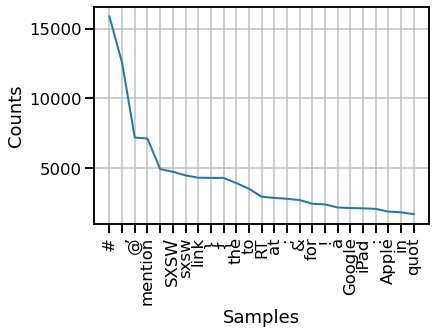

In [12]:

freq.plot(25);

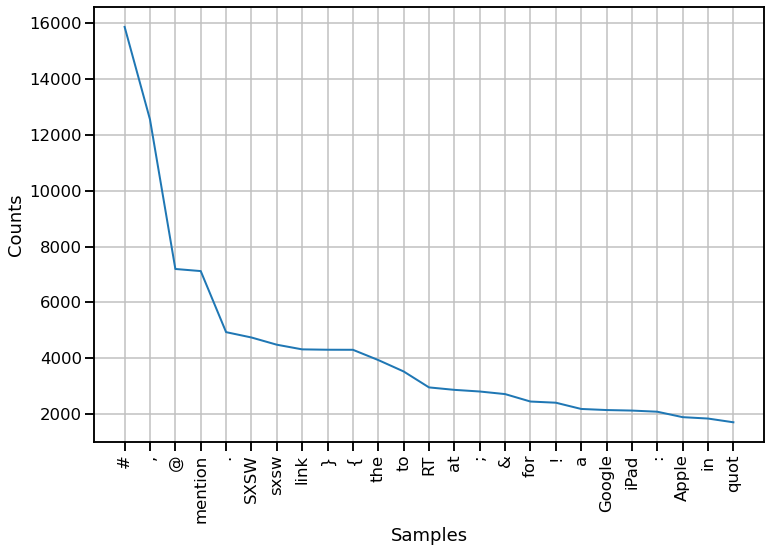

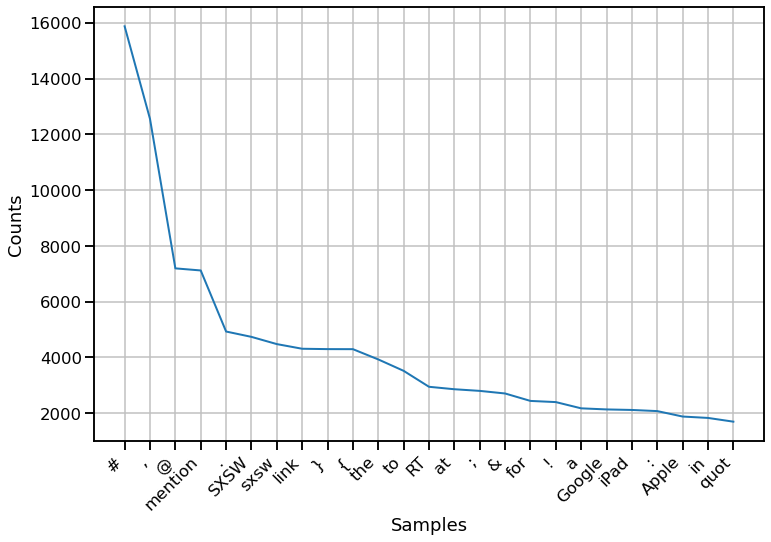

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
freq.plot(25);

## Rotate 
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,ha='right');
fig

<AxesSubplot:ylabel='word'>

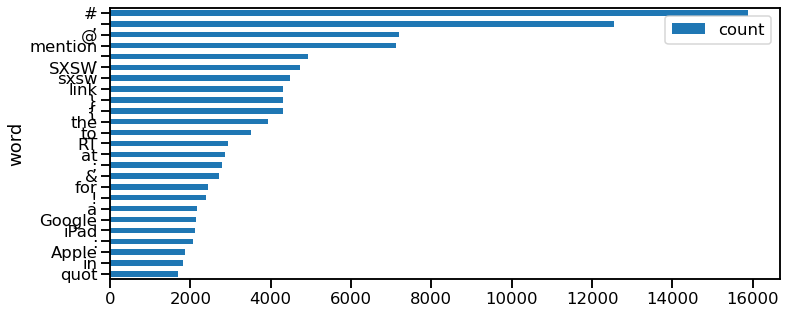

In [14]:
## Get the most_common 100 and make into a dataframe
most_common = pd.DataFrame(freq.most_common(100),
                           columns=['word','count']).sort_values('count',
                                                                 ascending=True)
most_common.set_index('word').tail(25).plot(kind='barh',figsize=(12,5))

In [15]:
most_common


,word,count
99,Today,250
98,ipad,251
97,'m,254
96,all,256
95,they,258
...,...,...
4,.,4929
3,mention,7119
2,@,7194
1,",",12554


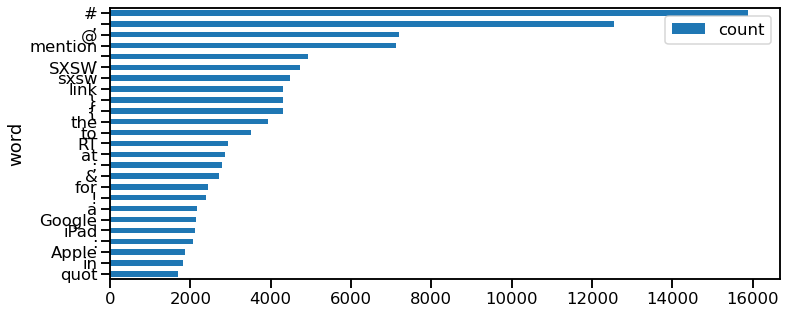

In [16]:
def plot_most_common(freq,n=25,figsize=(12,5)):
    most_common = pd.DataFrame(freq.most_common(n),
                           columns=['word','count']).sort_values('count',
                                                                 ascending=True)
    most_common.set_index('word').tail(n).plot(kind='barh',figsize=figsize)
    
plot_most_common(freq)

In [17]:
from nltk import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False,)
tweet_tokens = tokenizer.tokenize(','.join(corpus))
tweet_tokens[:20]

['.',
 '@wesley83',
 'i',
 'have',
 'a',
 '3g',
 'iphone',
 '.',
 'after',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#rise_austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'i']

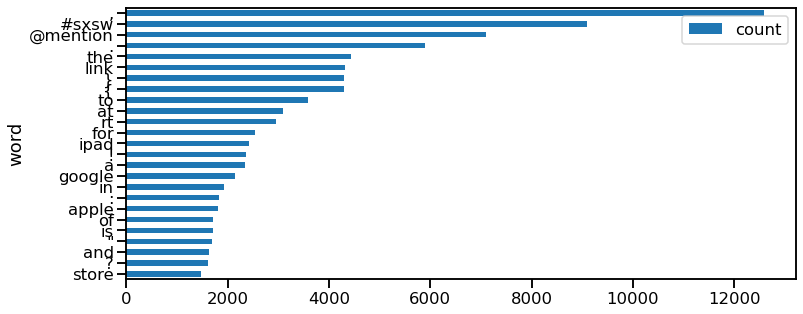

In [18]:
## Make a new freq dist for tweet tokens and plot most common
tweet_freq = FreqDist(tweet_tokens)
plot_most_common(tweet_freq)

In [19]:
## Make a list of stopwords to remove
from nltk.corpus import stopwords
import string

In [21]:
# Get all the stop words in the English language and preview first 10
stopwords_list = stopwords.words('english')
stopwords_list[:25]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers']

In [22]:
## Add punctuation to stopwords_list
stopwords_list.extend(string.punctuation)
stopwords_list[-10:]

['[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

In [23]:
## Add the additional Tweet Punctuation below to stopwords_list
additional_punc = ['“','”','...',"''",'’','``']
stopwords_list.extend(additional_punc)

In [24]:
len(stopwords_list)


217

In [25]:
## Remove stopwords
stopped_tokens= [w.lower() for w in tweet_tokens  if w.lower() not in stopwords_list]
stopped_tokens[:50]

['@wesley83',
 '3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 '#rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 '#sxsw',
 '@jessedee',
 'know',
 '@fludapp',
 'awesome',
 'ipad',
 'iphone',
 'app',
 'likely',
 'appreciate',
 'design',
 'also',
 "they're",
 'giving',
 'free',
 'ts',
 '#sxsw',
 '@swonderlin',
 'wait',
 '#ipad',
 '2',
 'also',
 'sale',
 '#sxsw',
 '@sxsw',
 'hope',
 "year's",
 'festival',
 'crashy',
 "year's",
 'iphone',
 'app',
 '#sxsw',
 '@sxtxstate',
 'great',
 'stuff',
 'fri',
 '#sxsw']

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


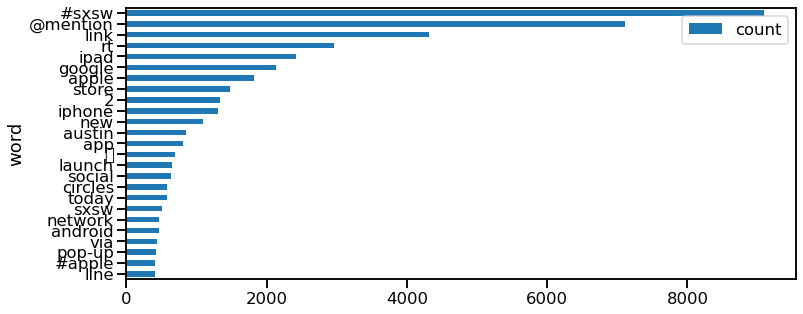

In [26]:
## Remake the FreqDist from stopped_tokens
freq = FreqDist(stopped_tokens)
plot_most_common(freq,25)

In [27]:
#### Appending our stopwords list
stopwords_list.extend(['…','rt','http','https','co'])
stopwords_list[-1]

'co'

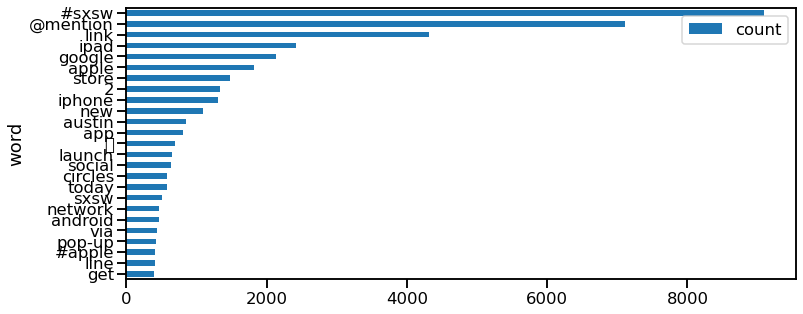

In [28]:
## Remake the FreqDist from stopped_tokens
stopped_tokens= [w.lower() for w in tweet_tokens  if w.lower() not in stopwords_list]
freq = FreqDist(stopped_tokens)
# freq.most_common(100)
plot_most_common(freq,25)

In [29]:
from wordcloud import WordCloud

## Initalize a WordCloud with our stopwords_list and no bigrams
wordcloud = WordCloud(stopwords=stopwords_list,collocations=True)

## Generate wordcloud from stopped_tokens
wordcloud.generate(','.join(stopped_tokens))

## Plot with matplotlib
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

ModuleNotFoundError: No module named 'wordcloud'

During our EDA, we looked at tweets with positive and negative sentiments as a whole as well as on a company and product level to answer the questions mentioned in the introduction section. Wordclouds were generated for each analysis. To be able to produce these graphics the tweets were tokenized with nltk's TweetTokenizer since it has built-in functionality for tweets specifically, lemmatized with the WordNetLemmatizer and stop words were removed from these tokens. We customized stop words to get a better view of the content of the tweets for addressing the questions.

### Comparing Phases of Proprocessing/Tokenization

In [31]:
from ipywidgets import interact

@interact
def tokenize_tweet(i=(0,len(corpus)-1)):
    from nltk.corpus import stopwords
    import string
    from nltk import word_tokenize,regexp_tokenize
    
    print(f"- Tweet #{i}:\n")
    print(corpus[i],'\n')
    tokens = word_tokenize(corpus[i])

    # Get all the stop words in the English language
    stopwords_list = stopwords.words('english')
    stopwords_list += string.punctuation
    stopwords_list += additional_punc
    stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopwords_list]
    
    print(tokens,end='\n\n')
    print(stopped_tokens)

interactive(children=(IntSlider(value=4546, description='i', max=9092), Output()), _dom_classes=('widget-inter…

### Bag of Words Stats

In [32]:
import nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

In [33]:
## Make a DataFrame from the Bigrams
pd.DataFrame(tweets_scored, columns=["Word","Freq"]).head(10)

,Word,Freq
0,"(#sxsw, @mention)",0.010167
1,"(ipad, 2)",0.009806
2,"(@mention, @mention)",0.008958
3,"(link, #sxsw)",0.007722
4,"(#sxsw, link)",0.007226
5,"(link, @mention)",0.006604
6,"(@mention, #sxsw)",0.005205
7,"(apple, store)",0.004917
8,"(@mention, google)",0.004258
9,"(social, network)",0.004078


In [34]:

bigram_measures = nltk.collocations.BigramAssocMeasures()

tweet_pmi_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweet_pmi_finder.apply_freq_filter(3)

tweet_pmi_scored = tweet_pmi_finder.score_ngrams(bigram_measures.pmi)

In [35]:
## Make a DataFrame from the Bigrams with PMI
pd.DataFrame(tweet_pmi_scored,columns=['Words','PMI']).head(20)

,Words,PMI
0,"(#accordion, #toodamnlucky)",15.173274
1,"(#kawasaki, #thisisdare)",15.173274
2,"(#mwrc11, left-brain)",15.173274
3,"(#pubcamp, #kirkus)",15.173274
4,"(#sxswlatam, #latinasintech)",15.173274
5,"(#videogames, #tyson)",15.173274
6,"(argues, exceptionally)",15.173274
7,"(barroom, brawls)",15.173274
8,"(boyfriend, aw)",15.173274
9,"(conceptual, graphing)",15.173274


### RegEx

In [36]:
len(corpus)

9093

In [37]:
## Select an example tweet
text =  corpus[9000]
text

'Dropped my MacBook pro as I was walking into #sxsw. iPad 2 sounding pretty appealing right now. Somehow I will adapt and overcome.'

In [43]:
## Select a second example tweet
text2=corpus[5]
text2

'@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd'

In [41]:
from nltk import regexp_tokenize
pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"
regexp_tokenize(text,pattern)

['Dropped',
 'my',
 'MacBook',
 'pro',
 'as',
 'I',
 'was',
 'walking',
 'into',
 'sxsw',
 'iPad',
 'sounding',
 'pretty',
 'appealing',
 'right',
 'now',
 'Somehow',
 'I',
 'will',
 'adapt',
 'and',
 'overcome']

In [ ]:
# Let's use regex to find/remove URLS

In [44]:
import re
re.findall(r"(http://\w*\.\w*/+\w+)",text2)

['http://ht.ly/49n4M']

In [45]:
def clean_text(text,regex=True):
    from nltk.corpus import stopwords
    import string
    from nltk import word_tokenize,regexp_tokenize

    ## tokenize text
    if regex:
        pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"
        tokens= regexp_tokenize(text,pattern)
    else:
        tokens = word_tokenize(text)
        
    # Get all the stop words in the English language
    stopwords_list = stopwords.words('english')
    stopwords_list += string.punctuation
    
    stopped_tokens = [w.lower() for w in tokens if w not in stopwords_list]
    
    return stopped_tokens

In [46]:
## Other uses of RegEx for Tweet preprocessing
import re

def find_urls(string): 
    return re.findall(r"(http[s]?://\w*\.\w*/+\w+)",string)

def find_hashtags(string):
    return re.findall(r'\#\w*',string)

def find_retweets(string):
    return re.findall(r'RT [@]?\w*:',string)

def find_mentions(string):
    return re.findall(r'\@\w*',string)

## Stemming/Lemmatization

In [47]:
def process_tweet(text,as_lemmas=False,as_tokens=True):
#     text=text.copy()
    for x in find_urls(text):
        text = text.replace(x,'')
        
    for x in find_retweets(text):
        text = text.replace(x,'')    
        
    for x in find_hashtags(text):
        text = text.replace(x,'')    

    if as_lemmas:
        from nltk.stem.wordnet import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        text = lemmatizer.lemmatize(text)
    
    if as_tokens:
        text = clean_text(text)
    
    if len(text)==0:
        text=''
            
    return text

In [49]:
# @interact
def show_processed_text(i=(0,len(corpus)-1)):
    text_in = corpus[i]#.copy()
    print(text_in)
    text_out = process_tweet(text_in)
    print(text_out)
    text_out2 = process_tweet(text_in,as_lemmas=True)
    print(text_out2)

In [50]:
corpus[:6]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd']

## Text Vectorization

* Count vectorization
* Term Frequency-Inverse Document Frequency (TF-IDF)
* Word Embeddings (Deep NLP)

### Summary: Feature Engineering for Text Data

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

# MODEL

## Text Classification - Sentiment Analysis

### Objective - Classifying Tweet Sentiments as Positive, Negative or Neither


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

Our modelling process was split in two: Binary Classification and Multiclass Classification. For each type of classification, data was prepared and a baseline dummy classifier model was trained to serve as a baseline. For comparison we trained/tested Random Forest models and Logistic Regression models for Multiclass Classification while adding on Multinomial Naive Bayes for the Binary Classification on top of these.

We evaluated each model and tuned hyperparameters with gridsearches that optimized for the recall macro scores since we wanted the models to correctly classify all classes. These steps were repeated after data was randomly oversampled.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

Tested Naive Bayes (Multinomial), Random Forest, and Logistic Regression classifiers
To determine optimal preprocessing steps, model type, and model hyperparameters, ran grid searches optimized for recall macro
Evaluated both binary (positive and negative) and multi-class (positive, negative, and no emotion) classification. Compared the all-in-one multi-class model to the performance if we used multi-class as the first pass, and the binary model as the second pass.

In [51]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [53]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [54]:
## Check Value Counts for Product
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [55]:
## Check Value Counts for Sentiment
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

## Preprocessing

In [56]:
## Make X and y
y = df['is_there_an_emotion_directed_at_a_brand_or_product'].copy()
X = df['tweet_text'].copy()
X

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: tweet_text, Length: 9093, dtype: object

### Train Test Split


In [57]:
## Train Test Split (random state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                    random_state=42)
X_train

2954    #UXdes @mention is glad there are no standard ...
2709    if you are ready to take your tech geekdom to ...
2357    #saveustechies panel at #sxsw getting off to a...
6195    RT @mention Join actsofsharing.com tonight.  t...
1366    @mention - spread the word, our #SXSW festival...
                              ...                        
5734    RT @mention For many of you that asked last ni...
5191    RT @mention &quot;So if you Google &quot;refri...
5390    RT @mention Android developers and friends: le...
860     So geeky! Love it! RT @mention Apple is openin...
7270    Anyone know of iPhone developers that will be ...
Name: tweet_text, Length: 6365, dtype: object

In [58]:
## Check y_train value counts
y_train.value_counts(1)

No emotion toward brand or product    0.595758
Positive emotion                      0.324116
Negative emotion                      0.062372
I can't tell                          0.017753
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

### Tokenization & Vectorization

In [59]:
## Make a TweekTokenizer from nltk.tokenize (preserve_case=False)
tokenizer = TweetTokenizer(preserve_case=False)

In [60]:
## Make a TfIdf Vectorizer using tweet tokenizer's .tokenize method
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                             stop_words=stopwords_list)

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

<6365x8950 sparse matrix of type '<class 'numpy.float64'>'
	with 74371 stored elements in Compressed Sparse Row format>

In [61]:
## Compare the shape of X_train to X_train_tfidf

X_train.shape

(6365,)

In [62]:
## Check the len of the vectorizer's vocabulary
len(vectorizer.vocabulary_)

8950

## Baseline Model

In [63]:
## Make and fit a random forest  (class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tfidf,y_train)


RandomForestClassifier(class_weight='balanced')

In [64]:
def evaluate_classification(model, X_test_tf,y_test,cmap='Greens',
                            normalize='true',classes=None,figsize=(10,4),
                            X_train = None, y_train = None,):
    """Evaluates a scikit-learn binary classification model.

    Args:
        model (classifier): any sklearn classification model.
        X_test_tf (Frame or Array): X data
        y_test (Series or Array): y data
        cmap (str, optional): Colormap for confusion matrix. Defaults to 'Greens'.
        normalize (str, optional): normalize argument for plot_confusion_matrix. 
                                    Defaults to 'true'.
        classes (list, optional): List of class names for display. Defaults to None.
        figsize (tuple, optional): figure size Defaults to (8,4).
        
        X_train (Frame or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
        y_train (Series or Array, optional): If provided, compare model.score 
                                for train and test. Defaults to None.
    """
    
    ## Get Predictions and Classification Report
    y_hat_test = model.predict(X_test_tf)
    print(metrics.classification_report(y_test, y_hat_test,target_names=classes))
    
    ## Plot Confusion Matrid and roc curve
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_tf,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                 ax=ax[0])
    
    ## if roc curve erorrs, delete second ax
    try:
        curve = metrics.plot_roc_curve(model,X_test_tf,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
    except:
        fig.delaxes(ax[1])
    plt.show()
    
    ## Add comparing Scores if X_train and y_train provided.
    if (X_train is not None) & (y_train is not None):
        print(f"Training Score = {model.score(X_train,y_train):.2f}")
        print(f"Test Score = {model.score(X_test_tf,y_test):.2f}")
        
    
def plot_importance(tree, X_train_df, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                              index=X_train_df.columns)
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances',
    ylabel='Feature',)
    return df_importance

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        43
                  Negative emotion       0.62      0.17      0.26       173
No emotion toward brand or product       0.66      0.88      0.76      1597
                  Positive emotion       0.64      0.39      0.48       915

                          accuracy                           0.66      2728
                         macro avg       0.48      0.36      0.38      2728
                      weighted avg       0.64      0.66      0.62      2728



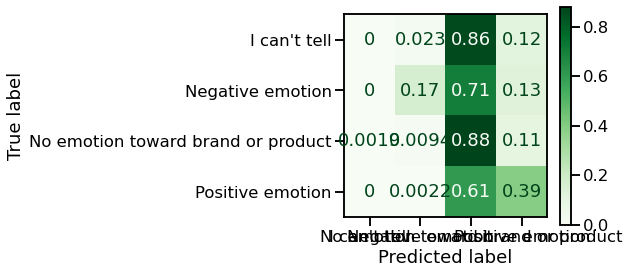

Training Score = 0.99
Test Score = 0.66


In [65]:
## Evaluate Model using function
evaluate_classification(rf,X_test_tfidf,y_test,X_train=X_train_tfidf,y_train=y_train)

In [66]:
pd.DataFrame(X_train_tfidf.todense(), columns=vectorizer.get_feature_names())

,##apple_store,##sxsw,#10,#11ntc,#120,#13,#1315,#1406-08,#1422,#1443,...,ûò,ûòand,ûó,ûócan,ûólewis,ûólots,ûómy,ûóthe,ü,ü_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


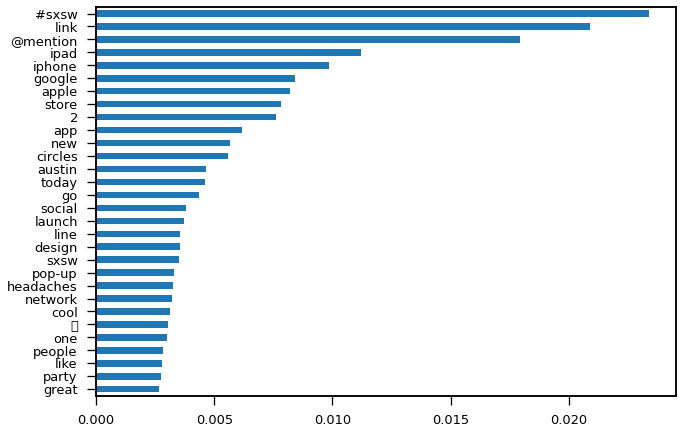

In [67]:
# Plot the top 30 most important features
with plt.style.context('seaborn-talk'):

    ## Get Feature Importance
    importance = pd.Series(rf.feature_importances_,
                           index=vectorizer.get_feature_names())

    ## Take the .tail 30 and plot kind='barh'
    importance.sort_values().tail(30).plot(kind='barh')

## Pipelines and GridSearch for NLP

In [68]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #TfidfVectorizer
from sklearn.pipeline import Pipeline

In [70]:
from sklearn import set_config
set_config(display='diagram')

In [73]:
text_pipe = Pipeline(steps=[
    ('count_vectorizer',CountVectorizer()),
    ('tf_transformer',TfidfTransformer(use_idf=True))
])
text_pipe

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tf_transformer', TfidfTransformer())])

In [74]:
## Test out the text pipeline on X_train
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

<6365x8286 sparse matrix of type '<class 'numpy.float64'>'
	with 103523 stored elements in Compressed Sparse Row format>

In [75]:
## Make a full pipeline with the random forest model as the second step
full_pipe = Pipeline([('text_pipe',text_pipe),
                     ('clf',RandomForestClassifier(class_weight='balanced'))])
full_pipe

Pipeline(steps=[('text_pipe',
                 Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                 ('tf_transformer', TfidfTransformer())])),
                ('clf', RandomForestClassifier(class_weight='balanced'))])

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        43
                  Negative emotion       0.63      0.14      0.23       173
No emotion toward brand or product       0.65      0.91      0.76      1597
                  Positive emotion       0.67      0.33      0.44       915

                          accuracy                           0.65      2728
                         macro avg       0.49      0.34      0.36      2728
                      weighted avg       0.65      0.65      0.61      2728



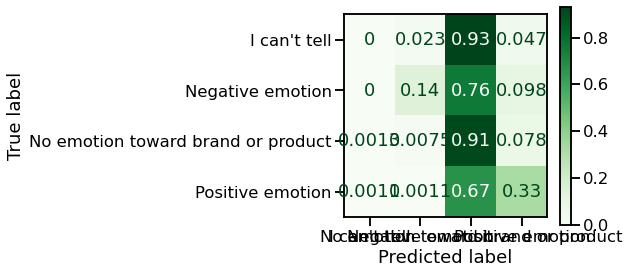

Training Score = 1.00
Test Score = 0.65


In [76]:
# Modeling with full pipeline
full_pipe.fit(X_train,y_train)
evaluate_classification(full_pipe,X_test,y_test,X_train=X_train, y_train=y_train)

### GridSearching NLP Pipeline

In [77]:
full_pipe.named_steps['text_pipe']

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tf_transformer', TfidfTransformer())])

In [78]:
## Make a tokenizer with TweetTokenizer

## Make params grid
## transformer params: use_idf/norm,smooth_idf
### tokenizers: try different TweetTokeinzier

## Vectorizer:stop_wqords/max_df/min_df,

## randomforest: criterin/max_depth
params = {'text_pipe__tf_transformer__use_idf':[True,False],
        'text_pipe__tf_transformer__norm':['l2','l1'],
         'text_pipe__tf_transformer__smooth_idf':[True,False],
          'text_pipe__count_vectorizer__stop_words':[stopwords_list,None],
#             'text_pipe__count_vectorizer__max_df':[1.0,0.95],
#           'text_pipe__count_vectorizer__min_df':[1,2,3],
          'clf__criterion':['gini','entropy'],
          'clf__max_depth':[None, 10, 30, 50]
         }

## Make and fit grid
grid = GridSearchCV(full_pipe,
                   params, cv=3, scoring='recall',n_jobs=-1,verbose=2)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
## Evluate the best_estimator
evaluate_classification(grid.best_estimator_, X_test,y_test, 
                        X_train=X_train, y_train=y_train)

### Get feature importances as text

### Gaussian Naive Bayes

In [ ]:

from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes.fit(X_tr,y_tr)
evaluate_classification(bayes,X_te,y_te,X_train=X_tr,y_train=y_tr)

In [79]:
## Use text pipe to get X_train,X_test
X_train_pipe = text_pipe.fit_transform(X_train)
X_test_pipe = text_pipe.transform(X_test)
X_train_pipe

<6365x8286 sparse matrix of type '<class 'numpy.float64'>'
	with 103523 stored elements in Compressed Sparse Row format>

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        43
                  Negative emotion       1.00      0.01      0.01       173
No emotion toward brand or product       0.62      0.97      0.75      1597
                  Positive emotion       0.75      0.19      0.30       915

                          accuracy                           0.63      2728
                         macro avg       0.59      0.29      0.27      2728
                      weighted avg       0.68      0.63      0.54      2728



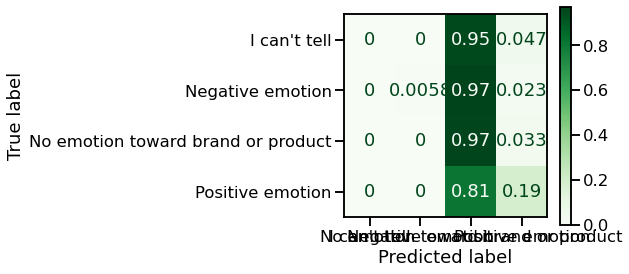

Training Score = 0.72
Test Score = 0.63


In [80]:
## Make a naive bayes classifier
nb_classifier = MultinomialNB()#alpha = 1.0e-08)
nb_classifier.fit(X_train_pipe,y_train)
evaluate_classification(nb_classifier,X_test_pipe,y_test, X_train=X_train_pipe,
                       y_train=y_train)

In [81]:
# Make a new pipeline for bayes

nb_pipe = Pipeline(steps=[
    ('text_pipe',text_pipe),
    ('clf',MultinomialNB())
])


params = {'text_pipe__tf_transformer__use_idf':[True, False],
          'text_pipe__tf_transformer__norm':['l2','l1'],
          'text_pipe__tf_transformer__use_idf':[True,False],
          'text_pipe__tf_transformer__smooth_idf':[True,False],
#           'text_pipe__count_vectorizer__tokenizer':[ 
# #               None,                                       
#               TweetTokenizer(preserve_case=True).tokenize,
#               TweetTokenizer(preserve_case=False).tokenize],
          
          'text_pipe__count_vectorizer__stop_words':[None,stopwords_list],
#           'text_pipe__count_vectorizer__max_df':[1.0,0.95,0.9],
#           'text_pipe__count_vectorizer__min_df':[1,2,3],
          
         'clf__alpha':[0, 1],
         'clf__fit_prior':[True,False]}


## Make and fit grid
grid = GridSearchCV(nb_pipe,params,cv=3,scoring='recall_macro',
                   verbose=2, n_jobs=-1)
grid.fit(X_train,y_train)
## Display best params
grid.best_params_


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   30.7s finished
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


{'clf__alpha': 0,
 'clf__fit_prior': False,
 'text_pipe__count_vectorizer__stop_words': None,
 'text_pipe__tf_transformer__norm': 'l1',
 'text_pipe__tf_transformer__smooth_idf': True,
 'text_pipe__tf_transformer__use_idf': False}

                                    precision    recall  f1-score   support

                      I can't tell       0.02      0.02      0.02        43
                  Negative emotion       0.35      0.32      0.33       173
No emotion toward brand or product       0.71      0.68      0.69      1597
                  Positive emotion       0.53      0.57      0.55       915

                          accuracy                           0.61      2728
                         macro avg       0.40      0.40      0.40      2728
                      weighted avg       0.61      0.61      0.61      2728



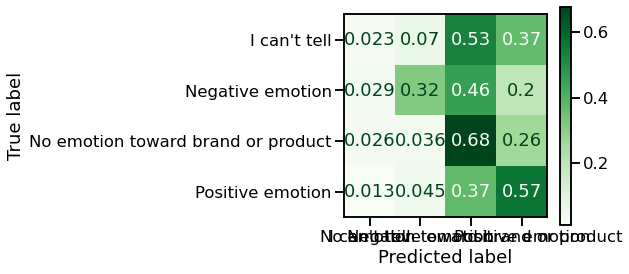

Training Score = 0.87
Test Score = 0.61


In [82]:
## Evluate the best_estimator
best_pipe = grid.best_estimator_
evaluate_classification(best_pipe,X_test,y_test,X_train=X_train,y_train=y_train)

## Best Model

The best model for both binary and muli-class classification problems were both Logistic Regression. The models agreed on most preprocessing and model hyperparameters, but differed in a few ways:

### Multi-Class Model Results

Best model achieved ~60-65% balanced accuracy across all classes on unseen test data
~30% better than guessing randomly based on class distribution
Identified about the same percentage of True Positives for any class, although confused Positive and No Sentiment more often than either of these with Negative

### Binary Model Results

Best model achieved ~75% balanced accuracy across both classes on unseen test data
~25% better than guessing randomly based on class distribution
Better at predicting positive sentiment than negative: only ~10-15% of Positives misclassified as Negative, while ~30-40% of Negatives misclassified as Positive

# Results

Evaluate how well your work solves the stated business problem.

The winner of this task was the tuned oversampled logistic regression model with a recall macro score of 0.62. The tuned random oversampled logistic regression model also scored the same 0.62; however, since it got to the same score only after the random oversampling we are declaring the non-oversampled model as the winner.



***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Model Insights

The word clouds generated from top predictors of Positive and Negative sentiment seemed to capture the emotions fairly well. Ultimately, SMEs would need to weigh in on whether reviewing samples of tweets based on these predictors provided insights they didn't already have from other sources of customer sentiment.

Just from having read through some sample tweets during my EDA and preprocessing, I was able to glean some basic themes around what people were tweeting positively about and what they were tweeting negatively about.



For example, SXSW attendees sounded pretty positive about the new iPad 2, which was newly released at the time. Apple also had a pop-up store in downtown Austin that garnered a lot of chatter: some positive, but also some negative because people were annoyed at having to wait in long line to enter.

People expressed frustration about the battery life of their phones, as well as certain apps which had been designed to run on iOS or Android.

One of the biggest challenges would be determining a reasonable way to review the full text of tweets with certain themes to try to determine actionable insights. For example, I'm not surprised that words such as "cool" and "free" were top predictors of positive sentiment, but we would need to know exactly what people thought was "cool" and what "free" things they liked most.

SMEs, especially those who were familiar with what events were hosted and what merchandise was given away for free, would certainly need to interpret these further. Separating tweets into posisitve, negative, and neutral would only be the first step: reviewing the tweets themselves to determine themes in positive and negative sentiment would also be necessary.

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

***

As a proof-of-concept, I demonstrated that even simple models such as Logistic Regression can be trained on labeled data to predict sentiment more accurately than random guessing.

Since the Logistic Regression models are easy to interpret, I think they could provide useful insights for business stakeholders at a company looking to inform marketing and product strategies. My recommended approach would be to use the multi-class model to separate positive and negative tweets, and use the binary model as a second step to pull out the most important predictors of each sentiment.

Although these simple models only give us feature importances of n-grams, if we built a simple tool to search for each n-gram as a keyword in tweets, we could pull samples for subject matter experts to review and interpret before determining any next steps.



***


Today, it is more important than ever for businesses to be in tune with their customers. "Listening" to the public opinion on their products and services not only allows for them to maintain financial success, but also provides them with opportunities to stay competitive in the market. To sum up, our analysis showed the following:

1. How is Apple perceived as a company during the SXSW Conference, and how does this compare to Google as one of their main competitors?

During the SXSW Conference, 81.1% of all tweets related to Apple were positive compared to Google's 82%.
During the SXSW Conference, 16.1% of all tweets related to Apple were negative compared to Google's 14.9%
This suggests that both companies and their products and services are perceived mostly in a positive way.

2. How are Apple and Google's products and announcements perceived during the SXSW Conference? Are there specific pain points within the products that Apple should address?

Apple - Positives:

Tweets about Apple suggest that the temporary pop-up store announcement in downtown Austin has been received very well by Apple fans and generated a lot of excitement for the brand.
One of the most frequently talked about products was the iPad 2 which seems to have been launched during SXSW and sold in the Austin temporary pop-up store. Based on the tweets, Apple's launch of this product definitely generated a lot of buzz.
Samplers and free products/services were frequently mentioned as well.
Apple - Negatives:

The iPhone's battery is frequently discussed in negative tweets.
Design of the iPad was referred to as a "design headache."
There are several tweets mentioning Kara Swisher and references to Apple as a "fascist company."
Several apps are referred to as "battery killer" and the design of the News app seems to have not been received positively.
Google - Positives:

Google's party in Lustre Pearl generated a lot of buzz.
Marissa Mayer is mentioned extensively, so her talk was positively received.
Google's new social network project "Circle" seems to have caused a lot of excitement.
Microsoft's Bing search engine is mentioned in a negative way.
Google - Negatives:

Some users seem to be having issues with Android OS based on words such as "buggy", "replaced", and "painful."
Samsung is mentioned in tweets with relation to Android suggesting some users may prefer it to Google's products.
Users of Meetup are having problems with Android.

## Recommendations

In light of the insights we provided above, our recommendations for Apple are as follows:

Users are not happy with iPhone's battery performance and therefore more R&D in this area may be needed.
Some users also don't seem to like the iPad's design. It may be fruitful to look more into this issue and potentially conduct a survey with users to understand the downsides of the current design.
Users seem to be having several issues with Android apps. This may be a great opportunity for Apple to make sure these issues don't exist in iOS and market their products to these users.
The marketing strategy for the new pop-up store seems to have been successful. It can be employed in conjuction with other conferences or major events.
Based on the response to Google's party, it may be effective to throw a party during the next SXSW Conference to generate excitement.

## Limitations & Next Steps

The dataset we used was a crowdsourced dataset which brings about certain challenges, one of which is that labeling tweets as "Positive", "Negative" or "No emotion" can be a highly subjective exercise. What I may think is a positive tweet, someone else may interpret as negative. Additionally, the context of these tweets matter. Since we don't know the methodology of how the data was labeled, there could have been human error in labeling where a tweet that was intended to be sarcastic can be labeled incorrectly for example. This would negatively impact the quality of the data.

Furthermore, our dataset consisted of 9,092 tweets which is a fairly small number. After removing neutral tweets we were only left with around 3,000 tweets for the binary classification. So, the amount of data used was limited. Additionally, the class imbalance was pretty significant with approximately 61% of data being neutral, 33% being positive and 6% being negative. Arguably, the "Negative" class would be much more important than the "Neutral" class in trying to understand where the areas of improvement are for Apple in general.

As next steps, if Apple would like to generalize these models for different applications, we would definitely gather more data from Twitter and potentially other sources. Additionally, if the data had to be labeled by humans, we would set guidelines for what each class of tweet would consist of with examples to make sure that the labels didn't solely rely on emotions. Furthermore, taking the average of sentiment labels for each tweet would result in more accurate labels.

Lastly, the performance of the models could be greatly improved by rethinking this project with Neural Networks. In the future we would use Deep NLP to classify tweets.